<h1>About The Dataset</h1>

<h2>Context</h2>
This classic dataset contains the prices and other attributes of almost 54,000 diamonds. It's a great dataset for beginners learning to work with data analysis and visualization.

<h2>Content</h2>
price price in US dollars (\$326--\$18,823)

carat weight of the diamond (0.2--5.01)

cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color diamond colour, from J (worst) to D (best)

clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

x length in mm (0--10.74)

y width in mm (0--58.9)

z depth in mm (0--31.8)

depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

table width of top of diamond relative to widest point (43--95)

link: https://www.kaggle.com/datasets/shivam2503/diamonds


<h1>Dataset Import & Exploration</h1>

In [18]:
import pandas as pd
import numpy as np
import os
from scipy.stats import shapiro
from pingouin import multivariate_normality
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import graphviz


In [19]:
df = pd.read_csv("diamonds.csv", sep=",", engine="python")
df.drop(["index"],axis=1, inplace=True)
#df.head()

In [20]:
# Missing value Checks
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0]

if not missing_df.empty:
    print("❌ MISSING VALUES DETECTED:")
    print(missing_df.sort_values('Missing %', ascending=False).to_string())
else:
    print("✅ NO MISSING VALUES FOUND")

# Duplicate row checks
duplicate_rows = df.duplicated().sum()
duplicate_pct = (duplicate_rows / len(df)) * 100

if duplicate_rows > 0:
    print(f"\n❌ DUPLICATE ROWS DETECTED: {duplicate_rows} ({duplicate_pct:.2f}%)")
    
    # Remove duplicates (keeping the first occurrence)
    df = df.drop_duplicates(keep='first')
    print(f"Removed {duplicate_rows} duplicate rows. New shape: {df.shape}")
    
    # Verify duplicates were removed
    remaining_duplicates = df.duplicated().sum()
    if remaining_duplicates == 0:
        print("✅ ALL DUPLICATES SUCCESSFULLY REMOVED")
    else:
        print(f"⚠️ WARNING: {remaining_duplicates} duplicates still remain")
else:
    print("\n✅ NO DUPLICATE ROWS FOUND")

✅ NO MISSING VALUES FOUND

❌ DUPLICATE ROWS DETECTED: 146 (0.27%)
Removed 146 duplicate rows. New shape: (53794, 10)
✅ ALL DUPLICATES SUCCESSFULLY REMOVED


In [21]:
continuous_cols = []
categorical_cols = []
targets = ["price","above_av"] #price is continous , above_av is binary
for col in df.columns:
    if col in targets:
        continue
    if df[col].nunique() <= 10:
        categorical_cols.append(col)

    else:
        continuous_cols.append(col)

print("Categorical columns are:\n",categorical_cols,"\n Continous ones are:\n",continuous_cols)
for col in categorical_cols:
    freq = df[col].value_counts(normalize=True) * 100
    print("\nValue Distribution (%):\n",freq.round(2).to_string())


Categorical columns are:
 ['cut', 'color', 'clarity'] 
 Continous ones are:
 ['carat', 'depth', 'table', 'x', 'y', 'z']

Value Distribution (%):
 cut
Ideal        39.94
Premium      25.56
Very Good    22.44
Good          9.09
Fair          2.97

Value Distribution (%):
 color
G    20.94
E    18.17
F    17.70
H    15.38
D    12.56
I    10.05
J     5.21

Value Distribution (%):
 clarity
SI1     24.23
VS2     22.73
SI2     17.01
VS1     15.16
VVS2     9.40
VVS1     6.78
IF       3.32
I1       1.38


In [6]:
df[continuous_cols].describe()

,carat,depth,table,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000


In [22]:
continuous_cols.append("price")
#multivariate_normality(df[continuous_cols], alpha=.05)

for col in continuous_cols:
    stat, p = shapiro(df[col].dropna())
    print(f"{col}: {'Normal' if p > 0.05 else 'Non-normal'} (p={p:.4f})")

carat: Non-normal (p=0.0000)
depth: Non-normal (p=0.0000)
table: Non-normal (p=0.0000)
x: Non-normal (p=0.0000)
y: Non-normal (p=0.0000)
z: Non-normal (p=0.0000)
price: Non-normal (p=0.0000)


c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


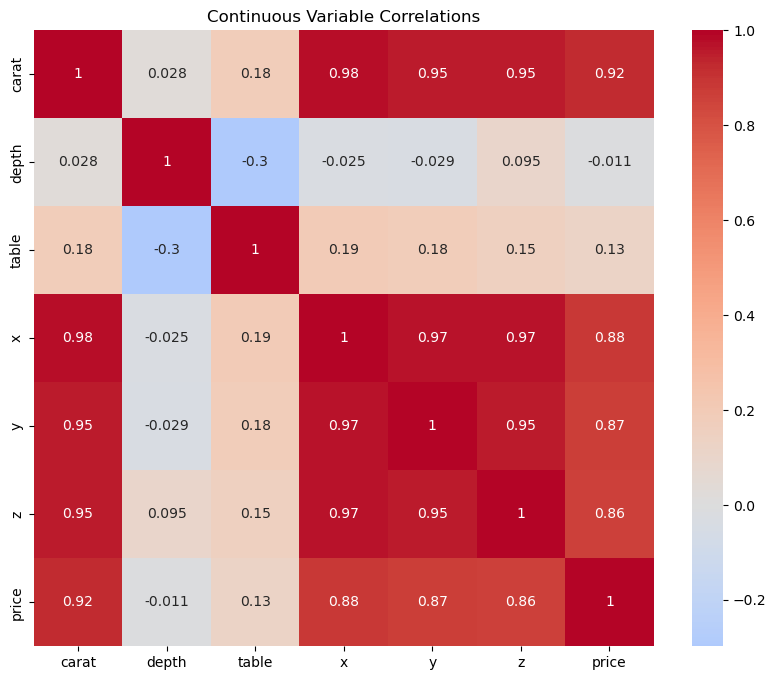

In [23]:

plt.figure(figsize=(10, 8))
sns.heatmap(df[continuous_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Continuous Variable Correlations")
plt.show()

In [10]:
X = df[continuous_cols].assign(intercept=1) 
vif_data = pd.DataFrame()
vif_data["Feature"] = continuous_cols
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(len(continuous_cols))]
vif_data = vif_data.sort_values("VIF", ascending=False)

vif_data

,Feature,VIF
3,x,57.159834
0,carat,33.054252
5,z,23.530434
4,y,20.456856
6,price,7.103215
1,depth,1.534395
2,table,1.166612


<h1>Analysis</h1>

<h2>Analysis Goals</h2>
1. Predicting price based on other features. Elastic Linear Reg, KNN, SVM, Neural Net. 

1.1 Are low correlation features worse predictors of price. 

2. Predicting if diamond will have better than average price. Decision Trees Elastic Log Reg, KNN, SVM, Neural Net 



In [24]:
df["above_av"] = (df["price"] > df["price"].mean()).astype(int)
freq = df["above_av"].value_counts(normalize=True) * 100
print("\nValue Distribution (%):\n",freq.round(2).to_string())

def chi2_test(df, cat_var, target_var='above_av'):
    contingency_table = pd.crosstab(df[cat_var], df[target_var])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-square test for {cat_var}:")
    print(f"Chi2 statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}, {'variables are not related' if p < 0.05 else 'variables are related'}")
    print("\n")

# Perform tests for each categorical variable
for col in ['cut', 'color', 'clarity']:
    chi2_test(df, col)


Value Distribution (%):
 above_av
0    63.56
1    36.44

Chi-square test for cut:
Chi2 statistic: 962.7753
P-value: 0.0000, variables are not related



Chi-square test for color:
Chi2 statistic: 1833.9149
P-value: 0.0000, variables are not related



Chi-square test for clarity:
Chi2 statistic: 2599.4054
P-value: 0.0000, variables are not related




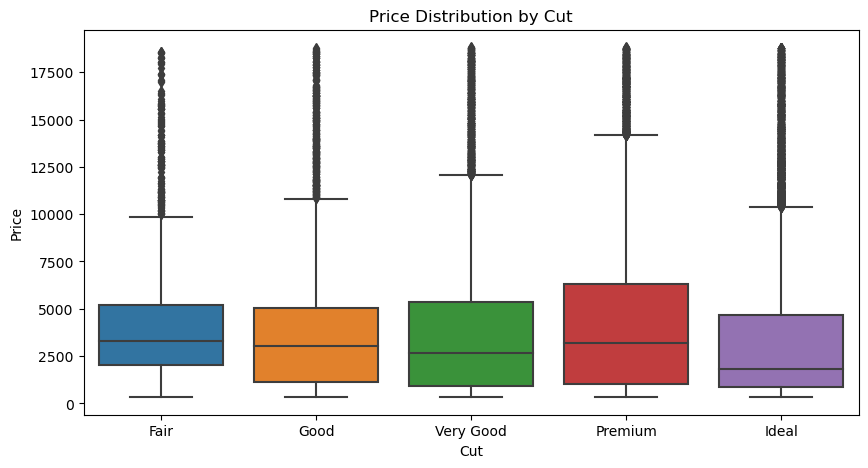

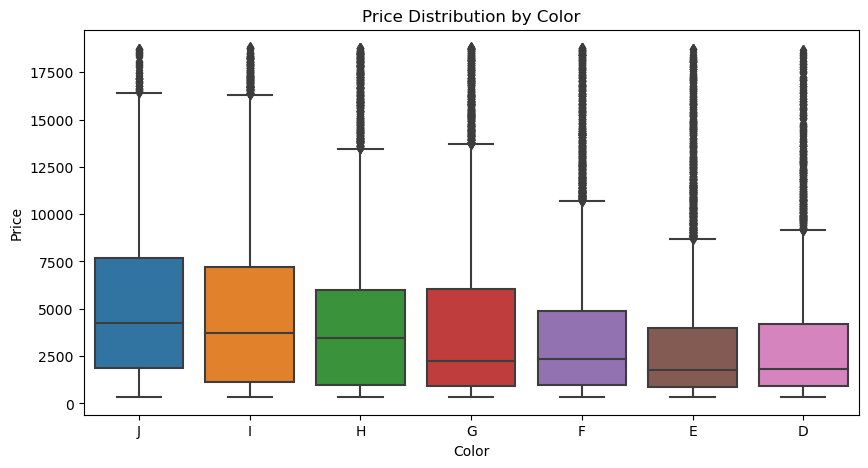

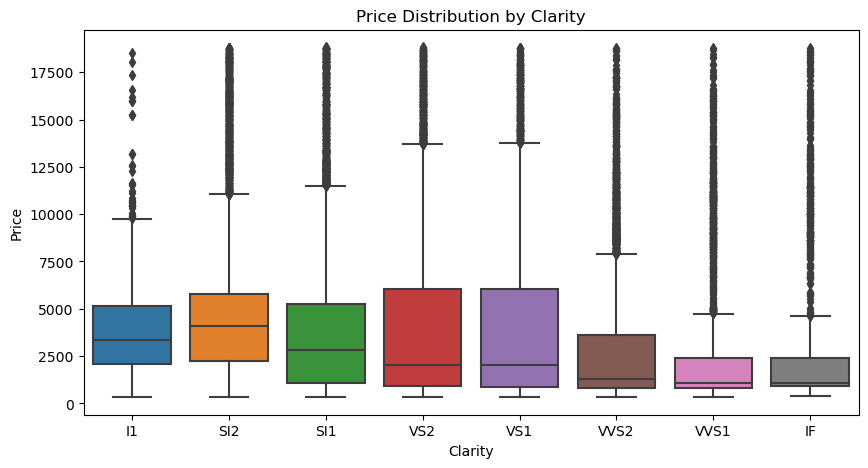

In [11]:
# Define proper orderings
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

# Mapping for order parameters
order_map = {
    'cut': cut_order,
    'color': color_order,
    'clarity': clarity_order
}

# Plot with correct ordering
for col in ['cut', 'color', 'clarity']:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=col, y='price', data=df, order=order_map[col])
    plt.title(f'Price Distribution by {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Price')
    plt.show()


<h1>Modelling</h1>

In [25]:
scaler = RobustScaler()
continuous_cols.remove("price")
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False , dtype=int)
x_cols = [x for x in df.columns if x not in targets]
X_train, X_test, y_train, y_test = train_test_split(df[x_cols],df["price"], test_size=0.33, random_state=15)
X_trainC, X_testC, y_trainC, y_testC = train_test_split(
    df[x_cols], 
    df["above_av"], 
    test_size=0.33, 
    random_state=15,
    stratify=df["above_av"]  # Key change
)

print("\nBalanced Class Distribution:")
print("Whole Data:",df['above_av'].value_counts(normalize=True))
print("Train:", y_trainC.value_counts(normalize=True))
print("Test:", y_testC.value_counts(normalize=True))


Balanced Class Distribution:
Whole Data: above_av
0    0.635573
1    0.364427
Name: proportion, dtype: float64
Train: above_av
0    0.635582
1    0.364418
Name: proportion, dtype: float64
Test: above_av
0    0.635555
1    0.364445
Name: proportion, dtype: float64


Training Regression Model


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e+09, tolerance: 4.579e+07
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e+09, tolerance: 4.602e+07
  model = cd_fast.enet_coordinate_descent(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e+09, toleranc

ElasticNet MSE: 1297050.7443 | Best params: {'alpha': 0.001}


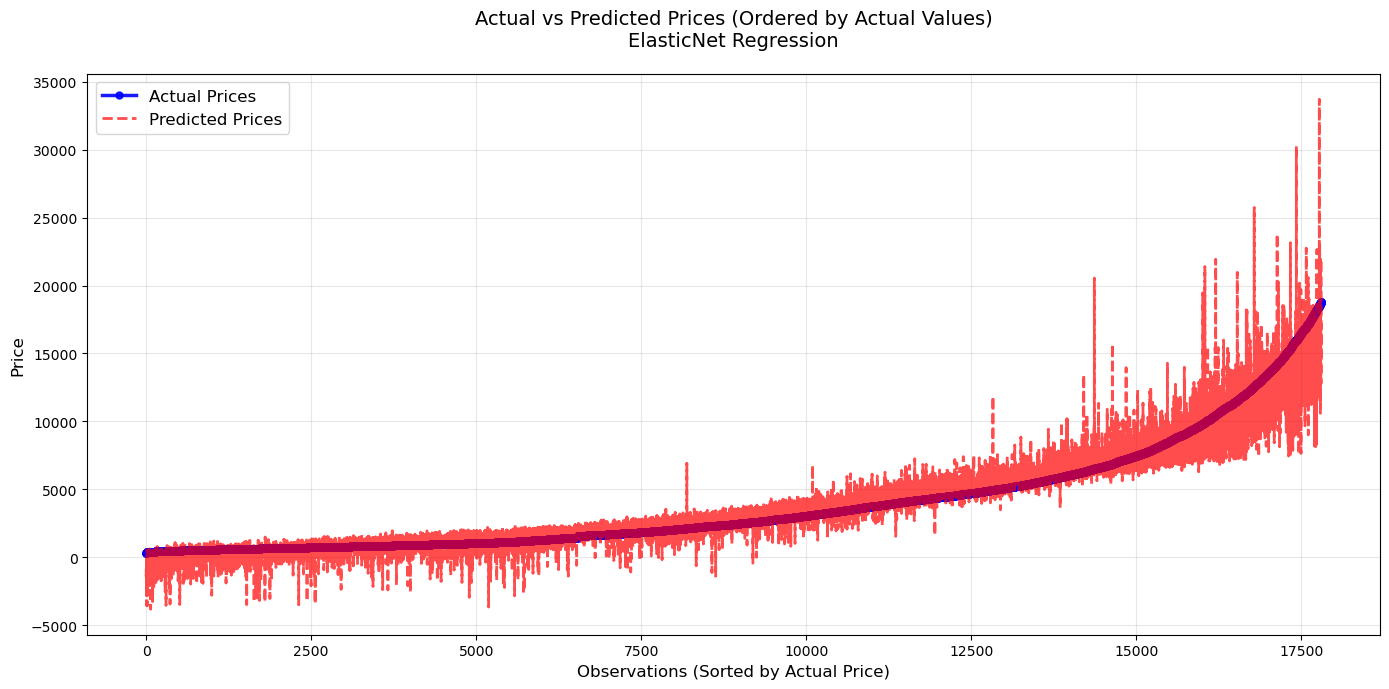

In [13]:
print("Training Regression Model")
enet = ElasticNet(random_state=15, l1_ratio=0.5)  # Fixed l1_ratio here
enet_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}  # Removed l1_ratio from params
enet_grid = GridSearchCV(enet, enet_params, cv=5, scoring='neg_mean_squared_error')
enet_grid.fit(X_train, y_train)
enet_pred = enet_grid.predict(X_test)
enet_mse = mean_squared_error(y_test, enet_pred)
print(f"ElasticNet MSE: {enet_mse:.4f} | Best params: {enet_grid.best_params_}")

# Generate predictions
enet_pred = enet_grid.predict(X_test)

# Sort by actual prices (ascending)
sorted_idx = np.argsort(y_test.values)
y_test_sorted = y_test.values[sorted_idx]
enet_pred_sorted = enet_pred[sorted_idx]

# Create the plot
plt.figure(figsize=(14, 7))

# Plot actual vs predicted (sorted)
plt.plot(y_test_sorted, label='Actual Prices', 
         color='blue', alpha=0.9, linewidth=2.5, marker='o', markersize=5)
plt.plot(enet_pred_sorted, label='Predicted Prices', 
         color='red', alpha=0.7, linewidth=2, linestyle='--')

# Customize the plot
plt.xlabel('Observations (Sorted by Actual Price)', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Actual vs Predicted Prices (Ordered by Actual Values)\nElasticNet Regression', 
          fontsize=14, pad=20)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Get the best estimator from GridSearch
best_enet = enet_grid.best_estimator_

# Create a DataFrame of coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_enet.coef_,
    'Absolute_Coeff': np.abs(best_enet.coef_)
})

# Sort by absolute value (most impactful features first)
coefficients = coefficients.sort_values('Absolute_Coeff', ascending=False)

# Display the coefficients
print("\nModel Coefficients:")
print(coefficients)


Model Coefficients:
          Feature  Coefficient  Absolute_Coeff
0           carat  7027.245839     7027.245839
18     clarity_I1 -3747.830400     3747.830400
3               x -1724.898745     1724.898745
17        color_J -1532.591955     1532.591955
19     clarity_IF  1529.880130     1529.880130
24   clarity_VVS1  1173.753593     1173.753593
25   clarity_VVS2  1113.271848     1113.271848
21    clarity_SI2 -1095.063886     1095.063886
11        color_D   814.944762      814.944762
22    clarity_VS1   744.270002      744.270002
16        color_I  -622.462030      622.462030
12        color_E   609.025846      609.025846
6        cut_Fair  -589.342971      589.342971
13        color_F   539.566200      539.566200
23    clarity_VS2   439.664561      439.664561
14        color_G   337.046884      337.046884
8       cut_Ideal   268.219002      268.219002
9     cut_Premium   177.786918      177.786918
20    clarity_SI1  -160.220135      160.220135
10  cut_Very Good   154.430190      154

Training Neural Net Model


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_m

Neural Network Reg MSE: 298745.7146 | Best params: {'hidden_layer_sizes': (50, 50)}


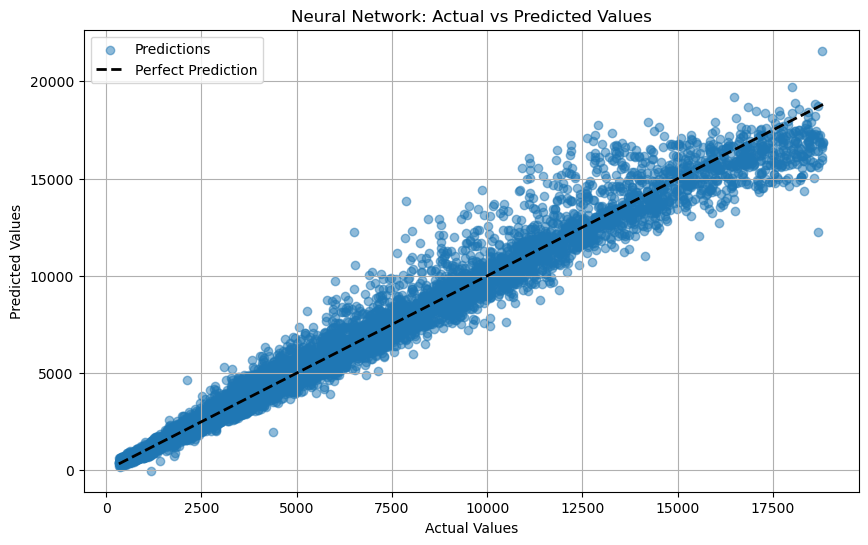

In [17]:
print("Training Neural Net Model")
# Neural Network Regression
nn_reg = MLPRegressor(random_state=15, max_iter=1000,activation="relu")
nn_reg_params = {'hidden_layer_sizes': [(50,), (100,), (50, 50)]}
nn_reg_grid = GridSearchCV(nn_reg, nn_reg_params, cv=3, scoring='neg_mean_squared_error')
nn_reg_grid.fit(X_train, y_train)
nn_reg_pred = nn_reg_grid.predict(X_test)
nn_reg_mse = mean_squared_error(y_test, nn_reg_pred)
print(f"Neural Network Reg MSE: {nn_reg_mse:.4f} | Best params: {nn_reg_grid.best_params_}")

# Get predictions
y_pred = nn_reg_grid.predict(X_test)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Neural Network: Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

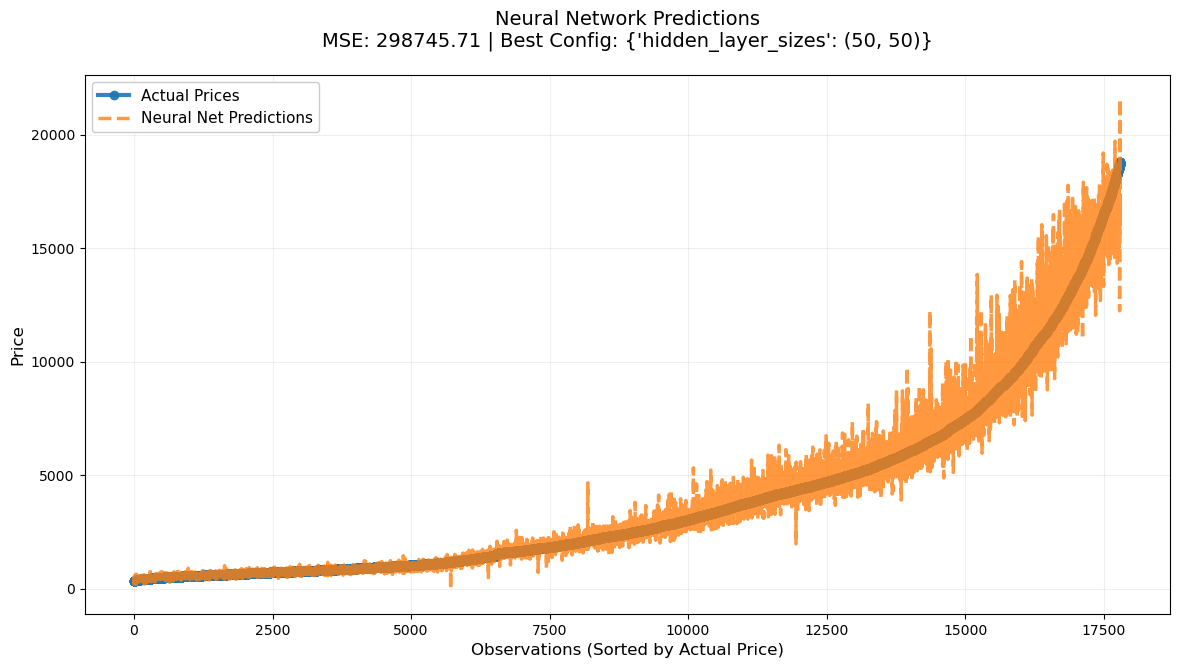

In [18]:
# Generate predictions
nn_pred = nn_reg_grid.predict(X_test)

# Sort by actual prices (ascending)
sorted_idx = np.argsort(y_test.values)
y_test_sorted = y_test.values[sorted_idx]
nn_pred_sorted = nn_pred[sorted_idx]

# Create the plot
plt.figure(figsize=(14, 7))

# Main plot lines
plt.plot(y_test_sorted, label='Actual Prices', 
         color='#1f77b4', alpha=0.9, linewidth=3, marker='o', markersize=6)
plt.plot(nn_pred_sorted, label='Neural Net Predictions', 
         color='#ff7f0e', alpha=0.8, linewidth=2.5, linestyle='--')



# Formatting
plt.xlabel('Observations (Sorted by Actual Price)', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title(f'Neural Network Predictions\nMSE: {nn_reg_mse:.2f} | Best Config: {nn_reg_grid.best_params_}', 
          fontsize=14, pad=20)
plt.legend(fontsize=11, framealpha=1)
plt.grid(True, alpha=0.2)

In [19]:

# Logistic Regression (with ElasticNet penalty)
logreg = LogisticRegression(penalty='elasticnet', solver='saga', random_state=15,l1_ratio=0.5)
logreg_params = {'C': [0.001, 0.01, 0.1, 1, 10], 
                    'l1_ratio': [0.5]}
logreg_grid = GridSearchCV(logreg, logreg_params, cv=5, scoring='accuracy')
logreg_grid.fit(X_trainC, y_trainC)
logreg_pred = logreg_grid.predict(X_testC)
logreg_acc = accuracy_score(y_testC, logreg_pred)
print(f"Logistic Regression Accuracy: {logreg_acc:.4f} | Best params: {logreg_grid.best_params_}")


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

Logistic Regression Accuracy: 0.9769 | Best params: {'C': 10, 'l1_ratio': 0.5}


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [20]:
# Neural Network Classification
nn_clf = MLPClassifier(random_state=15, max_iter=1000)
nn_clf_params = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 
                    'activation': ['relu']}
nn_clf_grid = GridSearchCV(nn_clf, nn_clf_params, cv=3, scoring='accuracy')
nn_clf_grid.fit(X_trainC, y_trainC)
nn_clf_pred = nn_clf_grid.predict(X_testC)
nn_clf_acc = accuracy_score(y_testC, nn_clf_pred)
print(f"Neural Network Clf Accuracy: {nn_clf_acc:.4f} | Best params: {nn_clf_grid.best_params_}")

Neural Network Clf Accuracy: 0.9787 | Best params: {'activation': 'relu', 'hidden_layer_sizes': (50,)}


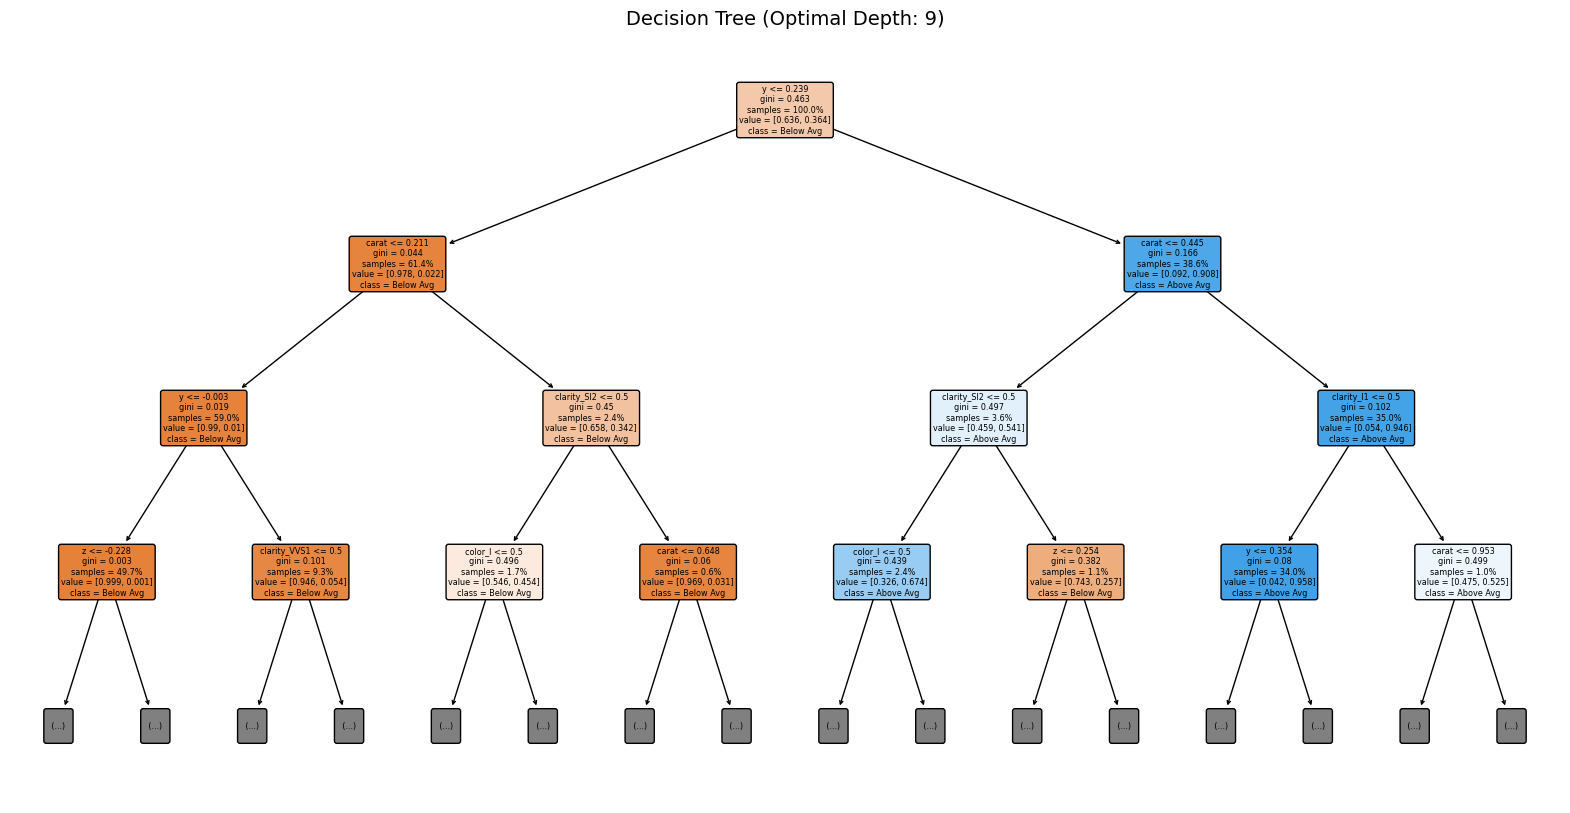

In [ ]:
# Decision Tree Classification
tree_clf = DecisionTreeClassifier(random_state=15)
tree_clf_params = {'max_depth': [3, 5, 7, ], 12, None]}
tree_clf_grid = GridSearchCV(tree_clf, tree_clf_params, cv=5, scoring='accuracy')
tree_clf_grid.fit(X_trainC, y_trainC)
best_tree = tree_clf_grid.best_estimator_  # Get best model

# Visualization
plt.figure(figsize=(20, 10))
plot_tree(best_tree,
          feature_names=list(X_trainC.columns),  # Explicit list conversion
          class_names=['Below Avg', 'Above Avg'],
          filled=True,
          rounded=True,
          proportion=True,
          max_depth=3)
plt.title(f"Decision Tree (Optimal Depth: {best_tree.get_depth()})", fontsize=14)
plt.show()

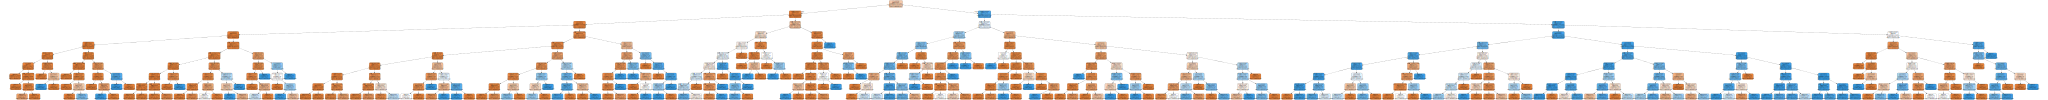

In [ ]:
#Run with privilaged CMD
#conda install -c conda-forge python-graphviz
#conda install -c conda-forge graphviz

dot_data = export_graphviz(best_tree,
                          feature_names=list(X_trainC.columns),  # Also needs list
                          class_names=['Below Avg', 'Above Avg'],
                          filled=True,
                          rounded=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Saves as PDF
graph  # Display in notebook

In [ ]:

print("Training SVM Model")
# Support Vector Regression
svr = SVR()
svr_params = {'C': [0.1, 1, 10], 
            'kernel': ['linear', 'rbf']}
svr_grid = GridSearchCV(svr, svr_params, cv=3, scoring='neg_mean_squared_error')
svr_grid.fit(X_train, y_train)
svr_pred = svr_grid.predict(X_test)
svr_mse = mean_squared_error(y_test, svr_pred)

print("Training KNN Model")
# KNN Regression
knn_reg = KNeighborsRegressor()
knn_reg_params = {'n_neighbors': [3, 5, 7, 9]}
knn_reg_grid = GridSearchCV(knn_reg, knn_reg_params, cv=5, scoring='neg_mean_squared_error')
knn_reg_grid.fit(X_train, y_train)
knn_reg_pred = knn_reg_grid.predict(X_test)
knn_reg_mse = mean_squared_error(y_test, knn_reg_pred)

print(f"SVR MSE: {svr_mse:.4f} | Best params: {svr_grid.best_params_}")
print(f"KNN Reg MSE: {knn_reg_mse:.4f} | Best params: {knn_reg_grid.best_params_}")



In [ ]:

# Support Vector Classification
svc = SVC(random_state=15)
svc_params = {'C': [0.1, 1, 10], 
                'kernel': ['linear', 'rbf']}
svc_grid = GridSearchCV(svc, svc_params, cv=3, scoring='accuracy')
svc_grid.fit(X_train, y_train)
svc_pred = svc_grid.predict(X_test)
svc_acc = accuracy_score(y_test, svc_pred)

# KNN Classification
knn_clf = KNeighborsClassifier()
knn_clf_params = {'n_neighbors': [3, 5, 7, 9]}
knn_clf_grid = GridSearchCV(knn_clf, knn_clf_params, cv=5, scoring='accuracy')
knn_clf_grid.fit(X_train, y_train)
knn_clf_pred = knn_clf_grid.predict(X_test)
knn_clf_acc = accuracy_score(y_test, knn_clf_pred)




# Print classification results
print("\nClassification Results:")

print(f"SVC Accuracy: {svc_acc:.4f} | Best params: {svc_grid.best_params_}")
print(f"KNN Clf Accuracy: {knn_clf_acc:.4f} | Best params: {knn_clf_grid.best_params_}")



# Print classification report for the best model
best_clf = max([(logreg_grid, logreg_acc), 
                (svc_grid, svc_acc), 
                (knn_clf_grid, knn_clf_acc), 
                (tree_clf_grid, tree_clf_acc), 
                (nn_clf_grid, nn_clf_acc)], key=lambda x: x[1])[0]
print("\nBest Classifier Report:")
print(classification_report(y_test, best_clf.predict(X_test)))

